In [1]:
# =======================
# IMPORTS
# =======================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, f1_score as sk_f1
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import random

In [2]:
# =======================
# CONFIGURATIONS
# =======================
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 20
TFLITE_PATH = "model.tflite"
SEED = 42
LOSS_FUNCTION = 'binary_crossentropy'
ARCHITECTURE = 'MobileNetV2'
ACTIVATION = 'leaky_relu'
OPTIMIZER = 'adamw'
THRESHOLD = 0.4
FINE_TUNE = True
FINE_TUNE_EPOCHS = 5
FINE_TUNE_LEARNING_RATE = 1e-5

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
train_path = r"C:\\Users\\Adars\\Desktop\\dataset\\train"
test_path = r"C:\\Users\\Adars\\Desktop\\dataset\\test"

In [3]:
# =======================
# FUNCTIONS
# =======================
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        cross_entropy = -K.log(p_t)
        loss = alpha_factor * K.pow(1 - p_t, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fn

def get_activation_function(name):
    if name == 'relu': return tf.keras.layers.ReLU()
    elif name == 'leaky_relu': return LeakyReLU(alpha=0.3)
    elif name == 'elu': return tf.keras.layers.ELU()
    else: return tf.keras.layers.ReLU()

def get_optimizer(name):
    if name == 'adam': return tf.keras.optimizers.Adam(learning_rate=1e-4)
    elif name == 'adamw': return tf.keras.optimizers.AdamW(learning_rate=1e-4)
    elif name == 'sgd': return tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
    elif name == 'rmsprop': return tf.keras.optimizers.RMSprop(learning_rate=1e-4)
    else: return tf.keras.optimizers.Adam(learning_rate=1e-4)

def f1_score(y_true, y_pred):
    y_pred = K.cast(y_pred > THRESHOLD, K.floatx())
    tp = K.sum(K.cast(y_true * y_pred, 'float'))
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'))
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

In [4]:
# =======================
# MODEL BUILDING
# =======================
def build_model(architecture, activation_fn):
    if architecture == 'MobileNetV2':
        base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'EfficientNetB0':
        base_model = EfficientNetB0(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'ResNet50':
        base_model = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'VGG16':
        base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'CNN':
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
            MaxPooling2D(2,2),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            Flatten(),
            Dense(256),
            activation_fn,
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        return model
    else:
        raise ValueError(f"Invalid architecture: {architecture}")

    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128),
        activation_fn,
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# =======================
# DATA GENERATORS
# =======================
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        zoom_range=0.3,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        seed=SEED
    )
    val_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        seed=SEED
    )
    test_gen = test_datagen.flow_from_directory(
        test_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    return train_gen, val_gen, test_gen

Found 7368 images belonging to 2 classes.
Found 1842 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/20


461/461 [==============================] - 187s 400ms/step - loss: 0.5111 - accuracy: 0.7788 - recall: 0.7856 - precision: 0.7668 - f1_score: 0.7713 - val_loss: 0.3176 - val_accuracy: 0.8692 - val_recall: 0.8882 - val_precision: 0.8364 - val_f1_score: 0.8541 - lr: 1.0000e-04
Epoch 2/20
461/461 [==============================] - 117s 254ms/step - loss: 0.4233 - accuracy: 0.8233 - recall: 0.8331 - precision: 0.8125 - f1_score: 0.8169 - val_loss: 0.3223 - val_accuracy: 0.8621 - val_recall: 0.8512 - val_precision: 0.8869 - val_f1_score: 0.8550 - lr: 1.0000e-04
Epoch 3/20
461/461 [==============================] - 127s 276ms/step - loss: 0.4018 - accuracy: 0.8339 - recall: 0.8515 - precision: 0.8180 - f1_score: 0.8288 - val_loss: 0.2749 - val_accuracy: 0.8903 - val_recall: 0.9131 - val_precision: 0.8688 - val_f1_score: 0

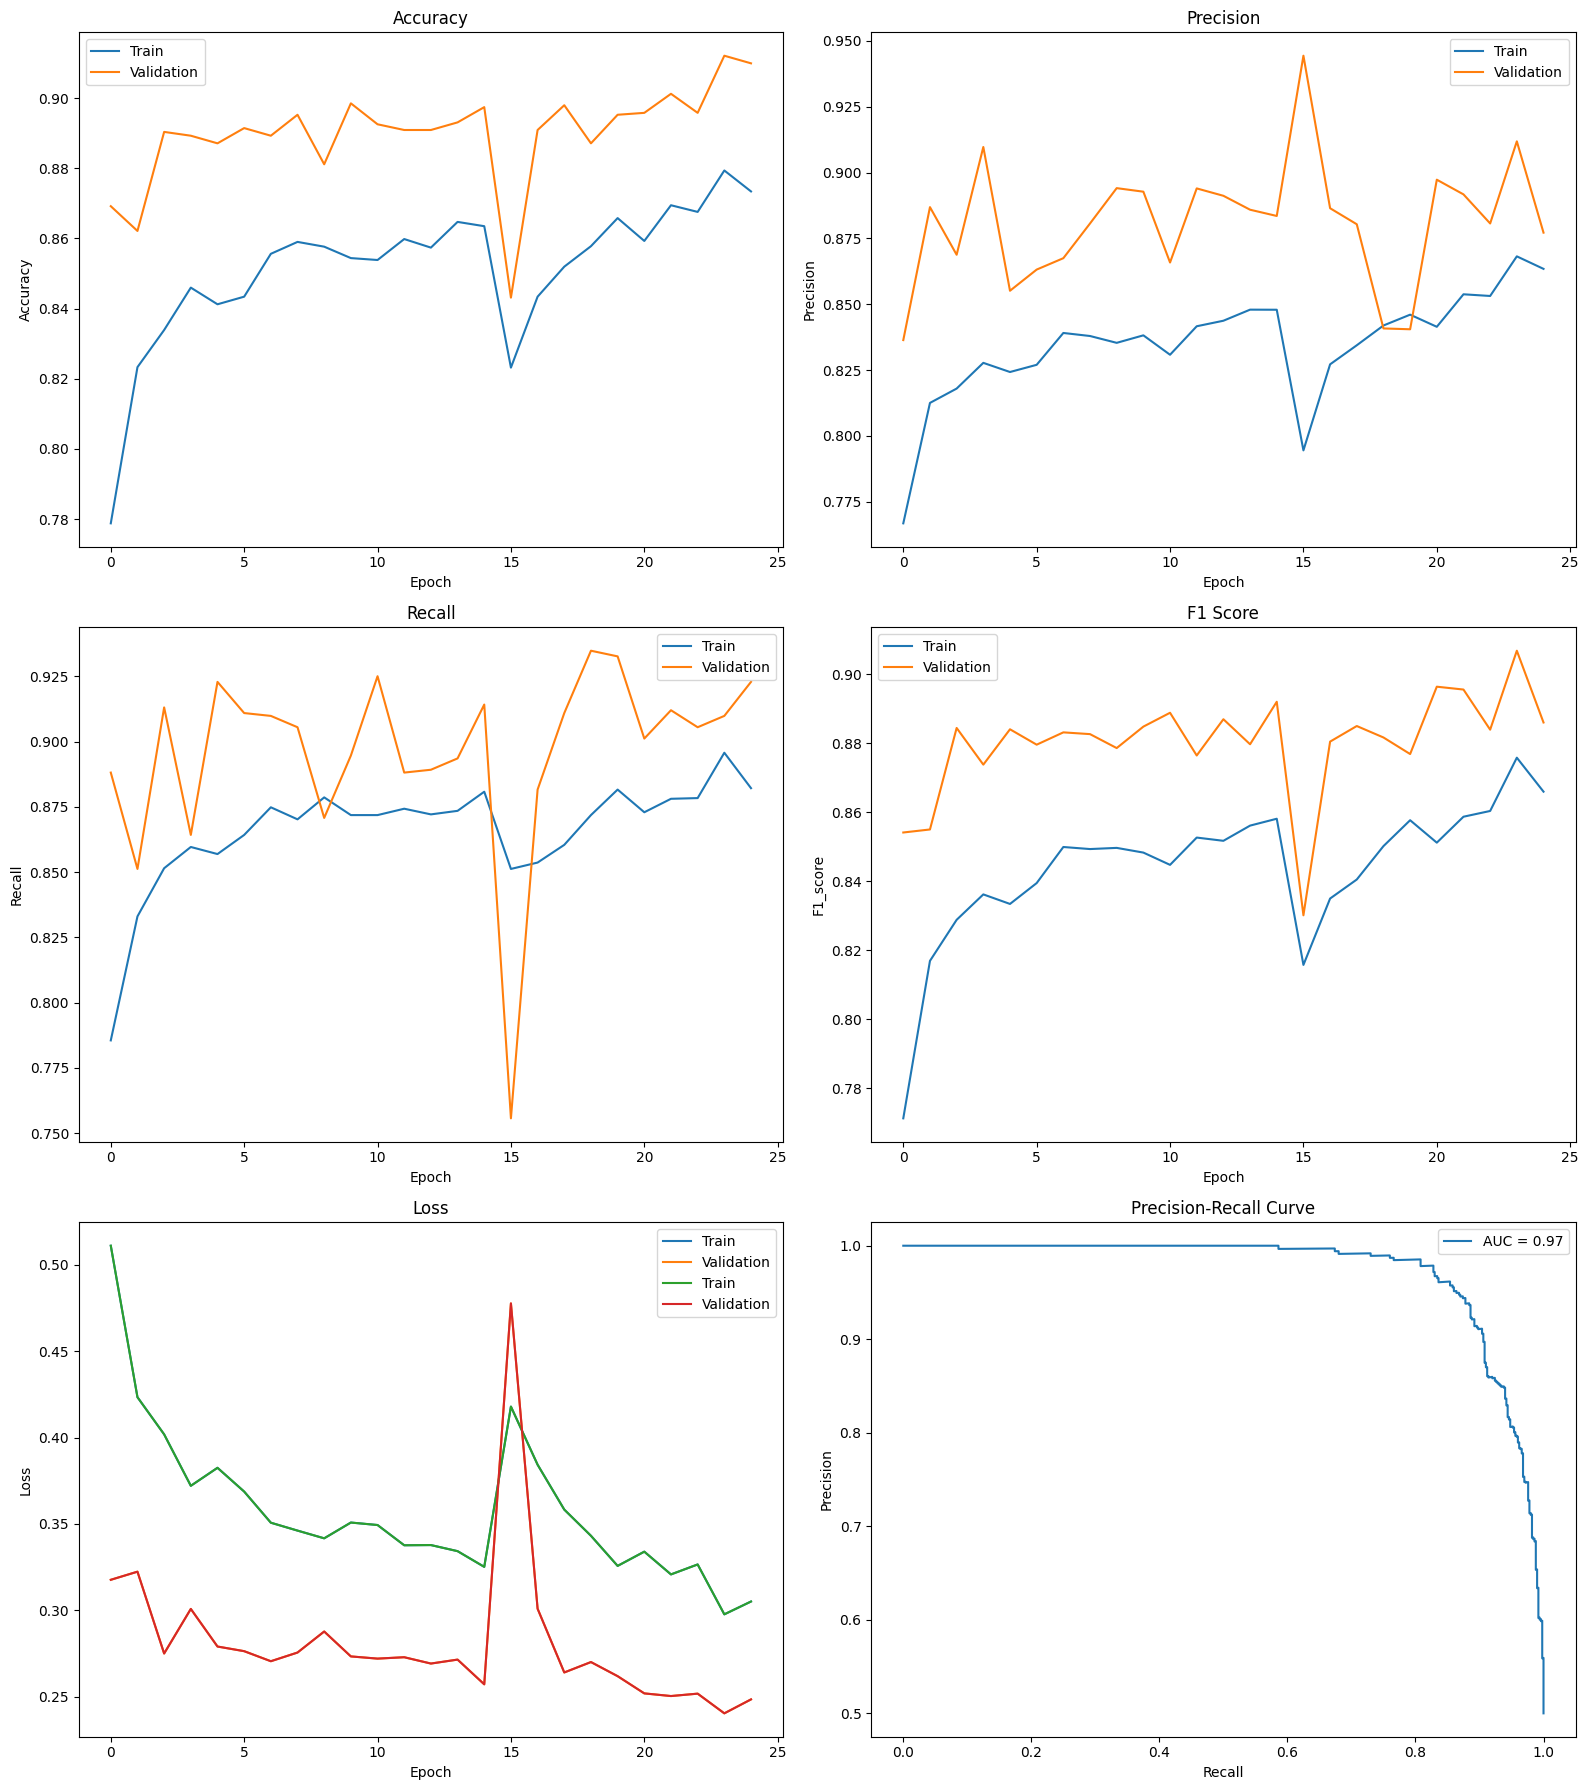

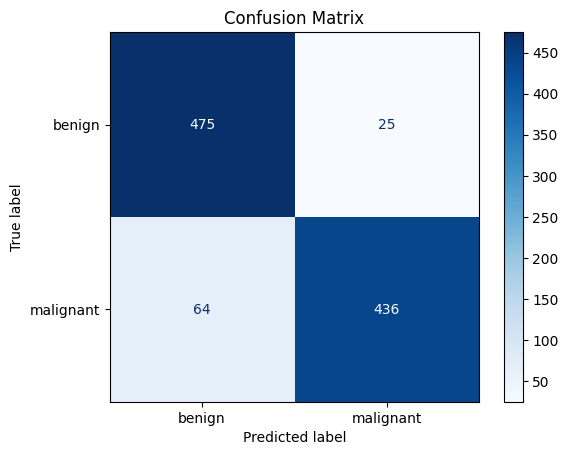

In [5]:
# =======================
# TRAINING & EVALUATION
# =======================
train_gen, val_gen, test_gen = create_data_generators()
model = build_model(ARCHITECTURE, get_activation_function(ACTIVATION))
loss = focal_loss() if LOSS_FUNCTION == 'focal' else 'binary_crossentropy'
custom_objects = {'focal_loss_fn': focal_loss(), 'LeakyReLU': LeakyReLU, 'f1_score': f1_score}
labels = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weight_dict}")
model.compile(
    optimizer=get_optimizer(OPTIMIZER),
    loss=loss,
    metrics=['accuracy',
             tf.keras.metrics.Recall(name='recall', thresholds=THRESHOLD),
             tf.keras.metrics.Precision(name='precision', thresholds=THRESHOLD),
             f1_score]
)
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )

if FINE_TUNE and ARCHITECTURE != 'CNN':
    base_model = model.layers[0]
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
        loss=loss,
        metrics=['accuracy',
                 tf.keras.metrics.Recall(name='recall', thresholds=THRESHOLD),
                 tf.keras.metrics.Precision(name='precision', thresholds=THRESHOLD),
                 f1_score]
    )
    history_fine = model.fit(
        train_gen,
        epochs=EPOCHS + FINE_TUNE_EPOCHS,
        initial_epoch=history.epoch[-1] + 1,
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )
    for key in history.history.keys():
        history.history[key] += history_fine.history[key]

model = tf.keras.models.load_model('best_model.keras', custom_objects=custom_objects)
test_results = model.evaluate(test_gen)
print(f"\nTest Metrics:\nLoss: {test_results[0]:.4f}\nAccuracy: {test_results[1]:.4f}\nRecall: {test_results[2]:.4f}\nPrecision: {test_results[3]:.4f}\nF1 Score: {test_results[4]:.4f}")
y_probs = model.predict(test_gen)
y_pred = (y_probs > THRESHOLD).astype(int)
plt.figure(figsize=(16, 18))

metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'loss']
titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Loss']

for i, metric in enumerate(metrics):
    plt.subplot(3, 2, i + 1)
    plt.plot(history.history[metric], label='Train')
    plt.plot(history.history[f'val_{metric}'], label='Validation')
    plt.title(titles[i])
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()

plt.subplot(3, 2, 5)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 6)
precision, recall, _ = precision_recall_curve(test_gen.classes, y_probs)
plt.plot(recall, precision, label=f'AUC = {auc(recall, precision):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(test_gen.classes, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=test_gen.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [6]:
# ==================
# MODEL EXPORT
# ==================
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()
with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)
print(f"\nTFLite model saved to: {TFLITE_PATH}")

# =================================
# METADATA ADDITION (NEW SECTION)
# =================================
def add_metadata():
    """Adds metadata to existing TFLite model without altering original code"""
    from tensorflow.lite.python.metadata import MetadataWriter
    
    # Get class labels from existing training generator
    class_labels = sorted(train_gen.class_indices.keys(), 
                        key=lambda k: train_gen.class_indices[k])
    
    # Create labels file
    labels_path = "labels.txt"
    with open(labels_path, "w") as f:
        f.write("\n".join(class_labels))
    
    # Create metadata
    metadata = {
        "name": "SkinClassifier",
        "description": f"Threshold={THRESHOLD} Skin/Non-Skin Detector",
        "version": "v1",
        "author": "User",
        "inputs": [{
            "name": "input",
            "description": "224x224 RGB image",
            "type": "IMAGE",
            "normalization": {
                "mean": [0],
                "std": [255]
            }
        }],
        "outputs": [{
            "name": "output",
            "description": "Skin probability score",
            "type": "TENSOR_FLOAT32",
            "associated_files": [{
                "name": labels_path,
                "description": "Class labels",
                "type": "TENSOR_AXIS_LABELS"
            }]
        }]
    }
    
    # Load existing model and add metadata
    with open(TFLITE_PATH, "rb") as f:
        model_buffer = f.read()
    
    writer = MetadataWriter(model_buffer)
    writer.add_metadata(metadata)
    updated_model = writer.populate()
    
    # Save updated model
    with open(TFLITE_PATH, "wb") as f:
        f.write(updated_model)
    print(f"Metadata added to {TFLITE_PATH}")

# Execute metadata addition
add_metadata()

# ==================
# FINAL MODEL INFO
# ==================
model.summary()

INFO:tensorflow:Assets written to: C:\Users\Adars\AppData\Local\Temp\tmp5ephnv4i\assets


INFO:tensorflow:Assets written to: C:\Users\Adars\AppData\Local\Temp\tmp5ephnv4i\assets



TFLite model saved to: model.tflite


ModuleNotFoundError: No module named 'tensorflow.lite.python.metadata'